## Support Vector Classifier for genre, based on 4 simple features

Trained with k fold cross validation and a loop over multple shufflings of the data.
Features used are the meadians of the simple feature vectors for each song.

Choose between linear and RBF kernel and between taking the mean or the median over the data. 

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [17]:
# Data import

genres = ["classical", "electronic", "pop", "rock"]

ZC = np.load('../preprocessing/SimpleFeatures/zeroCrossings_frame200ms_hop100ms.npy')
SC = np.load('../preprocessing/SimpleFeatures/spectralCentroid_frame200ms_hop100ms.npy')
SV = np.load('../preprocessing/SimpleFeatures/spectralVariance_frame200ms_hop100ms.npy')
ST = np.load('../preprocessing/SimpleFeatures/staticTempoLibrosa.npy')

In [18]:
# Take the median over all frames for each song to have comparable dimensions

ZC = np.nanmedian(ZC, axis=1)
SC = np.nanmedian(SC, axis=1)
SV = np.nanmedian(SV, axis=1)

In [19]:
# OR take the mean in a certain interval

# ZC = np.mean(ZC[:, 100:200], axis=1)
# SC = np.mean(SC[:, 100:200], axis=1)
# SV = np.mean(SV[:, 2:4], axis=1)

In [20]:
# Make dataframe

features_dict_medians = {'ZC': ZC,
                         'SC': SC,
                         'SV': SV,
                         'StaticTempo': ST}
features = pd.DataFrame(data=features_dict_medians)

ones = np.ones(100, dtype='int')
labels_dict = {'label': np.concatenate((ones, ones*2, ones*3, ones*4))}
labels = pd.DataFrame(labels_dict)

In [21]:
# Shuffle

def shuffleData(features, labels):
    n_data = len(features)
    idx = np.random.permutation(n_data)
    features, labels = features.reindex(idx), labels.reindex(idx)
    return features, labels

In [22]:
# K fold Crossvalidation

def kFoldConfusionMatrix(k, features, labels):

    kfold_train_metrics = []
    kfold_test_metrics = []

    confusion_Matrix = np.zeros((4,4))

    # # Drop NaN values
    # NaNidx = np.where(features.isnull().any(axis=1).tolist())[0]
    # # NaNidx = np.isnan(features)[np.isnan(features) == 1].stack().index.tolist()

    # total_input = features.drop(NaNidx)
    # total_labels = labels.drop(NaNidx)

    total_input = features
    total_labels = labels

    cv = KFold(n_splits=k)

    for train_index, test_index in cv.split(total_input):

        train_df, train_labels = total_input.iloc[train_index], total_labels.iloc[train_index]
        test_df, test_labels = total_input.iloc[test_index], total_labels.iloc[test_index]

        # Standardizing data
        mean = train_df.mean()
        std = train_df.std()

        train_df = (train_df - mean) / std
        test_df = (test_df - mean) / std

        # Classifier
        clf = svm.SVC(decision_function_shape='ovo', kernel='linear') # One versus one SVM classifier with RBF kernel
        clf.fit(train_df, np.squeeze(train_labels.to_numpy()))

        kfold_train_metrics.append(clf.score(train_df, train_labels))
        kfold_test_metrics.append(clf.score(test_df, test_labels))

        confusion_Matrix += confusion_matrix(test_labels, clf.predict(test_df), labels=[1,2,3,4])
        
    return confusion_Matrix

In [23]:
# Doing the actual training of the support vector classifier over multple rounds of shuffeling

confusion_Matrix = np.zeros((4,4))

N_shuffles = 20
k = 10
accuracies = []

for Siter in range(N_shuffles):
    features, labels = shuffleData(features, labels)
    confusion_Matrix += kFoldConfusionMatrix(k, features, labels)
    
    accuracies.append(np.sum(np.eye(4)*confusion_Matrix)/np.sum(confusion_Matrix))

In [24]:
# Confusion matrix
confusion_Matrix

array([[1634.,  118.,  120.,  128.],
       [ 797.,  284.,  445.,  474.],
       [ 234.,  236.,  599.,  931.],
       [ 234.,  143.,  823.,  800.]])

In [25]:
# CM = ConfusionMatrixDisplay(confusion_Matrix)
# CM.plot()

In [26]:
print(f'Accuracy: {np.mean(accuracies)} +- {np.std(accuracies)}')

Accuracy: 0.4087824894044079 +- 0.004873725711047766


In [27]:
# Normalize confusion matrix

confusion_matrix_N = confusion_Matrix / np.sum(confusion_Matrix, axis=1)[:, np.newaxis]
confusion_matrix_N

array([[0.817 , 0.059 , 0.06  , 0.064 ],
       [0.3985, 0.142 , 0.2225, 0.237 ],
       [0.117 , 0.118 , 0.2995, 0.4655],
       [0.117 , 0.0715, 0.4115, 0.4   ]])

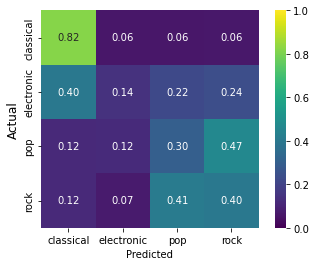

In [28]:
fig,ax = plt.subplots()
sns.heatmap(confusion_matrix_N, annot=True, fmt='.2f', xticklabels=genres, yticklabels=genres, vmin=0, vmax=1, cmap='viridis')
plt.ylabel('Actual', size=12)
plt.xlabel('Predicted')
plt.gca().set_aspect('equal')
plt.show(block=True)

fig.savefig('genre_confusion_matrix_N_linear.png', bbox_inches="tight")